# Airline Delay Prediction Project
---

The final aim of this project is to create a model that can predict the extent of delay for any given flight. This notebook and its outputs are based on all United States Domestic Flights in 2006 (7,000,000 flights)

NOTE : A brief description of outputs will be below each figure.  A more in depth analysis within the context of developing a Machine Learning Model will be provided at the bottom of the notebook.

### Notebook Introduction
---
The purpose of this notebook is to complete an Exploratory Data Analysis on the 2006 US Domestic Flight Dataset, downloaded from kaggle. The next notebook will focus on solving a classification problem - predicting the class of delay of a given flight. This work undertaken in this notebook will be used to optimise Machine Learning Models in the forthcoming notebook.

In this notebook I will:
- Create a SQL database which contains all flight data for many decades
- Query this database to select the variables and year (2006) that I am interested in.
- Store this data within a Pandas DataFrame for ease of access and manipulation.
- Import additional data from other sources to create a more comprehensive dataset + new feature engineering (airport and runway data).
- Engineer new features based on existing features such as Season, Time of Day, and departure time (mins after midnight).
    


### Importing Libraries + Working Directories
---

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import os
import zipfile
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

cwd = os.getcwd()
os.chdir(r"C:\Users\oskar\Documents\Projects\Portfolio Projects\US-Flight-Delay1")
cwd

'c:\\Users\\oskar\\Documents\\Projects\\Portfolio Projects\\US-Flight-Delay2'

## Uploading Data to SQLite DataBase
---

- This section uploads the large airline.csv file to the SQLite Database, from where we can filter which data we would like to extract.
- Note : Uncomment this code on first run of script.

In [2]:
# Create Database for kaggle data
#conn = sqlite3.connect('airline_database.db') #creates a database for the kaggle data

#chunksize = 600000 #processing 600000 lines at a time - you can adjust based on your own computing power.
#csv_file_path = 'airline.csv.shuffle' # replace with your file path containing kaggle data
#table_name = 'airline_data' #table name in sqlite

# Read the CSV and upload each chunk to the SQLite database
#for chunk in pd.read_csv(csv_file_path, chunksize=chunksize, encoding='ISO-8859-1'):
    #chunk.to_sql(name=table_name, con=conn, if_exists='append')

#Inside this loop, each chunk is appended to our SQL database using pandas .to_sql method

## Querying the SQLite DataBase
---

- "LIMIT" can be removed or added from the query line to change number of rows of data placed into dataframe. 

- In this case LIMIT is removed so all 7,000,000 records are included in the plane_df

In [3]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('airline_database.db')

# Define the desired column names. 
# The below list can be removed to reveal other variables that I chose not to include in the project.
column_names = ['Origin', 'Dest', 'Distance', 'DayOfWeek', 'DayofMonth', 'Month',
                'Year', 'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime',
                'UniqueCarrier', 'ArrDelay','Cancelled','Diverted', "DepDelay"]

# Constructing the SQL Query
query = "SELECT {} FROM airline_data WHERE Year = 2006;".format(','.join(column_names))
#If you do not want to explore all 7,000,000 flights, you can include a LIMIT clause followed by number of data entries.

# Execute query and push into dataframe
plane_df = pd.read_sql_query(query, conn, index_col=None) 

# Close the database connection
conn.close()

len(plane_df)

7176292

# Feature Engineering + Additional Data Collection
---

### Remove rows of data for flights that were diverted/cancelled + making separate dataframes for each for further analysis in the future.

In [4]:
div_canc = plane_df[(plane_df["Diverted"]==1)|(plane_df["Cancelled"]==1)]
div_canc.to_csv("diverted_cancelled.csv")
plane_df = plane_df.drop(plane_df[(plane_df["Cancelled"]==1)|(plane_df["Diverted"]==1)].index)
len(plane_df)

7037471

### Generate Season Column
---
The seasons are defined as spring (March, April, May), summer (June, July, August), autumn (September, October, November) and winter (December, January, February).

In [5]:
spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]
winter = [12,1,2]

def season_func(month):
    if month in spring:
        return "Spring"
    elif month in summer:
        return "Summer"
    elif month in autumn:
        return "Autumn"
    elif month in winter:
        return "Winter"
    else: 
        return "Unknown"

plane_df["Season"] = plane_df["Month"].apply(season_func)
plane_df.head()

#This code creates and applies a function that converts a month into a function.
#A list is created for each season, with associated months of the year.
#The function is applied to the month column to create a season column.


,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season
0,CVG,CMH,116.0,1,19,6,2006,1030,48.0,1118,OH,2.0,0,0,5.0,Summer
1,GNV,ATL,300.0,1,6,11,2006,1045,97.0,1222,EV,-2.0,0,0,-5.0,Autumn
2,ATL,SGF,563.0,7,30,7,2006,2035,112.0,2127,EV,136.0,0,0,153.0,Summer
3,HPN,ATL,780.0,4,21,12,2006,600,140.0,820,FL,4.0,0,0,1.0,Winter
4,PBI,BDL,1133.0,1,31,7,2006,1200,170.0,1450,DL,-4.0,0,0,0.0,Summer


### Loading + Merging Data for number of runways
---
- Including helipads + small runways at origin airport, arrival airport and total number of airports
- Additional data will be used to supplement Kaggle Airline Data


In [6]:
#airport + runway data sourced from https://ourairports.com/
airports = pd.read_csv("airports.csv")   #includes information about US airports
airports = airports[["id", "name", "iata_code"]]
airports.head()

#As we can see below, we have airport ID and their respective names.

,id,name,iata_code
0,6523,Total Rf Heliport,NaN
1,323361,Aero B Ranch Airport,NaN
2,6524,Lowell Field,NaN
3,6525,Epps Airpark,NaN
4,506791,Katmai Lodge Airport,NaN


In [7]:
runways = pd.read_csv("runways.csv") #includes information about runways.
runways = runways[["airport_ref","id",]]
no_runways = pd.DataFrame(runways["airport_ref"].value_counts().reset_index())
no_runways.columns = ["id", "no_runways"]
no_runways.head() #We now have a dataframe with airport id and the number of runways it has.

,id,no_runways
0,3754,11
1,300162,10
2,18256,9
3,8413,8
4,20654,8


- Merging the above 2 csv files to create a dataframe with airport + runway information, as we need to associate each ID with a name and IATA code.
---

In [8]:
merged_df = pd.merge(airports, no_runways, how="inner", on="id") #inner join on the id column
merged_df = merged_df.dropna(subset=["iata_code"], axis=0)
merged_df = merged_df.set_index("iata_code") #setting the iata_codes as the index.

merged_df.head()

,id,name,no_runways
iata_code,,,
UTK,4650,Utirik Airport,1
OCA,6924,Ocean Reef Club Airport,1
PQS,7063,Pilot Station Airport,1
CSE,7139,Crested Butte Airpark,1
JCY,7545,LBJ Ranch Airport,1


In [9]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season
0,CVG,CMH,116.0,1,19,6,2006,1030,48.0,1118,OH,2.0,0,0,5.0,Summer
1,GNV,ATL,300.0,1,6,11,2006,1045,97.0,1222,EV,-2.0,0,0,-5.0,Autumn
2,ATL,SGF,563.0,7,30,7,2006,2035,112.0,2127,EV,136.0,0,0,153.0,Summer
3,HPN,ATL,780.0,4,21,12,2006,600,140.0,820,FL,4.0,0,0,1.0,Winter
4,PBI,BDL,1133.0,1,31,7,2006,1200,170.0,1450,DL,-4.0,0,0,0.0,Summer


### Mapping this new airport + runway information into the original dataframe.
---

In [10]:
plane_df['origin_runways'] = plane_df['Origin'].map(merged_df['no_runways'])
#creates a new column in plane_df by mapping the Origin airport codes in plane_df to the corresponding number of runways found in merged_df

plane_df['destination_runways'] = plane_df['Dest'].map(merged_df['no_runways'])
#Does the same, but for destination airports.

#there was info missing for 1 airport, so manually filled it in.
plane_df['origin_runways'] = plane_df['origin_runways'].fillna(1)
plane_df['destination_runways'] = plane_df['destination_runways'].fillna(1)

plane_df["total_runways"] = plane_df["origin_runways"] + plane_df["destination_runways"]
#created a new column containing the total number of runways involved on a journey between origin and dest
#if airport A and B have 3 and 7 runways respectively, the total runways 'involved' would be 10.


### Converting Departure time to minutes after midnight
- 2.36pm would become 916 minutes after midnight.
---

In [11]:
# Convert CRSDepTime to a string and add leading zeros using an anonymous lambda function.
#Each time converted to an integer, then into a string. If less than 4 characters, leading gaps are filled with 0's.
plane_df['CRSDepTime'] = plane_df['CRSDepTime'].apply(lambda x: str(int(x)).zfill(4))

# Convert CRSDepTime to a datetime time object - hour represented by first two characters.
plane_df['CRSDepTime'] = pd.to_datetime(plane_df['CRSDepTime'], format='%H%M').dt.time

#For each dep time, the hour attribute is found *60 to get minutes, then adding minutes using minute attribute.
plane_df['CRSDepTimeMins_after_0000'] = plane_df['CRSDepTime'].apply(lambda x: x.hour*60 + x.minute)

### Converting Departure Time to Departure Time Frames
---
- Did the flight leave in the morning, afternoon, evening or night?

In [12]:
#setting time-bound variables to assign time of days
morning_start = datetime.time(6, 0, 0) 
morning_end = datetime.time(11, 59, 59)

afternoon_start = datetime.time(12, 0, 0)
afternoon_end = datetime.time(17, 59, 59)

evening_start = datetime.time(18, 0, 0)
evening_end = datetime.time(23, 59, 59)

night_start = datetime.time(0, 0, 0)
night_end = datetime.time(5, 59, 59)

def time_frame(time): #defining a function that returns time of day on a datetime variable.
    if morning_start <= time<= morning_end:
        return "Morning"
    elif afternoon_start <= time <= afternoon_end:
        return "Afternoon"
    elif evening_start <= time <= evening_end:
        return "Evening"
    elif night_start <= time <= night_end:
        return "Night"
    else: 
        return "Unknown"

plane_df["CRSDepTimeFrame"] = plane_df["CRSDepTime"].apply(time_frame)
#The above code creates a function that is applied to the departure time variable to determine time of day of departure.

### Mapping runways to origins and destinations
---

In [13]:
#Creates a new column : origin_runways. 
#For each row in origin column, it looks up the value of runways from the merged_df dataframe for that value.
#The same process takes place for destinations.
plane_df['origin_runways'] = plane_df['Origin'].map(merged_df['no_runways'])
plane_df['destination_runways'] = plane_df['Dest'].map(merged_df['no_runways'])

#There was info missing for 1 airport, so manually filling it in. Airport IATA code was PFN
plane_df['origin_runways'] = plane_df['origin_runways'].fillna(1)
plane_df['destination_runways'] = plane_df['destination_runways'].fillna(1)

#Creating new column "total_runways"
plane_df["total_runways"] = plane_df["origin_runways"] + plane_df["destination_runways"]


### Defining Primary Airports
---
Primary Airports are Commercial Service Airports that have more than 10,000 passenger boardings each year.
- I want to keep airports that are in the top 100 for total yearly outbound flights
- Coincidentally, the top 100 are the airports that have 10,000 flights minimum (2006)

In [14]:
#Slicing the top 100 value counts of origin airports and taking the index (airport abbreviation) and storing in a list.
top100_airports = plane_df["Origin"].value_counts()[:100].index.tolist()

#If an airport is part of the top100_airports list, it remains in the original dataframe.
#Filtered using a boolean mask.
plane_df = plane_df[plane_df['Origin'].isin(top100_airports)]
#After removing rows, resetting index for sequential readability. Dropping the old index so not converted to a new column.
plane_df = plane_df.reset_index(drop=True)

## Preparing for a Classification Problem
- In the next notebooks, I will be building models to predict how delayed a flight will be.
- Converting numeric target variable into a categorical variable.
---

In [15]:
#Function used to define how late a flight is in words, which is then applied to the ArrDelay column.
#New column ArrDelayClass is now created.
def classify_delay(delay):
    if delay <= 0:
        return 'On-time'
    elif delay <= 15:
        return 'Slightly delayed'
    elif delay <= 60:
        return 'Moderately delayed'
    else:
        return 'Excessively delayed'

plane_df["ArrDelayClass"] = plane_df["ArrDelay"].apply(classify_delay)

In [16]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season,origin_runways,destination_runways,total_runways,CRSDepTimeMins_after_0000,CRSDepTimeFrame,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,2006,10:30:00,48.0,1118,OH,2.0,0,0,5.0,Summer,4.0,2.0,6.0,630,Morning,Slightly delayed
1,ATL,SGF,563.0,7,30,7,2006,20:35:00,112.0,2127,EV,136.0,0,0,153.0,Summer,5.0,2.0,7.0,1235,Evening,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,2006,12:00:00,170.0,1450,DL,-4.0,0,0,0.0,Summer,3.0,3.0,6.0,720,Afternoon,On-time
3,PIT,PHL,267.0,3,27,12,2006,16:50:00,70.0,1800,US,-11.0,0,0,-4.0,Winter,4.0,4.0,8.0,1010,Afternoon,On-time
4,ORD,ANC,2846.0,7,23,7,2006,19:20:00,399.0,2259,AS,-2.0,0,0,8.0,Summer,11.0,3.0,14.0,1160,Evening,On-time


## Feature Engineering
#### Creating Additional Columns to measure airspace congestion (Domestic + By Airport)
---
- American Airspace Congestion("USair_congestion"): Simply how many domestics flights occurred within US airspace on a given day.
- I made the assumption that if there are more flights taking place on a given day, there is more chance for airline congestion to occur due to signal failures and human errors.
- Therefore, delays are more likely. This could be useful information for any models.

In [17]:
#Creating a new Date column based on the Day of Month and Month columns.
#All data is in 2006,so starting with 2006 in string form.
#Taking the month column and converting the number to a string, then using another hyphen to separate. Doing the same with day of month.
#Should end up with something like: '2006-6-19' for example. The format is YYYY-MM-DD.

plane_df["Date"] = pd.to_datetime('2006-' + plane_df["Month"].astype(str) + '-' + plane_df["DayofMonth"].astype(str), format='%Y-%m-%d')

daily_flights = plane_df.groupby("Date").size() #Groups by date, and each group has .size() applied to it, essentially counting each dates occurence.

#Here we create the new column - USair_congestion
#For each row, the date column is taken and mapped to the daily flight variable created above.
plane_df["USair_congestion"] = plane_df['Date'].map(daily_flights) 
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season,origin_runways,destination_runways,total_runways,CRSDepTimeMins_after_0000,CRSDepTimeFrame,ArrDelayClass,Date,USair_congestion
0,CVG,CMH,116.0,1,19,6,2006,10:30:00,48.0,1118,OH,2.0,0,0,5.0,Summer,4.0,2.0,6.0,630,Morning,Slightly delayed,2006-06-19,18246
1,ATL,SGF,563.0,7,30,7,2006,20:35:00,112.0,2127,EV,136.0,0,0,153.0,Summer,5.0,2.0,7.0,1235,Evening,Excessively delayed,2006-07-30,18083
2,PBI,BDL,1133.0,1,31,7,2006,12:00:00,170.0,1450,DL,-4.0,0,0,0.0,Summer,3.0,3.0,6.0,720,Afternoon,On-time,2006-07-31,18956
3,PIT,PHL,267.0,3,27,12,2006,16:50:00,70.0,1800,US,-11.0,0,0,-4.0,Winter,4.0,4.0,8.0,1010,Afternoon,On-time,2006-12-27,18814
4,ORD,ANC,2846.0,7,23,7,2006,19:20:00,399.0,2259,AS,-2.0,0,0,8.0,Summer,11.0,3.0,14.0,1160,Evening,On-time,2006-07-23,18043


### Origin and Destination Airport Congestion
---
- The next feature to create is airport airspace congestion. On a given day, how many flights did an airport receive/deliver? A column will be created for both origin and destination airport.


In [18]:
daily_takeoffs_by_airport = plane_df.groupby(["Date", "Origin"]).size() #how many flights took off for each combination of airport and day.
daily_landings_by_airport = plane_df.groupby(["Date", "Dest"]).size() #how many flights landed at each airport per day.

#renaming columns for clarity + reset index

daily_takeoffs_by_airport = daily_takeoffs_by_airport.reset_index().rename(columns={'Origin': 'Airport', 0: 'Count'})
daily_landings_by_airport = daily_landings_by_airport.reset_index().rename(columns={'Dest': 'Airport', 0: 'Count'})

daily_takeoffs_by_airport.head(7), daily_landings_by_airport.head(7)

(        Date Airport  Count
 0 2006-01-01     ABQ     91
 1 2006-01-01     ALB     38
 2 2006-01-01     ANC     50
 3 2006-01-01     ATL    968
 4 2006-01-01     AUS     93
 5 2006-01-01     BDL     81
 6 2006-01-01     BHM     50,
         Date Airport  Count
 0 2006-01-01     ABE     12
 1 2006-01-01     ABI      6
 2 2006-01-01     ABQ     91
 3 2006-01-01     ABY      3
 4 2006-01-01     ACT      5
 5 2006-01-01     ACV      9
 6 2006-01-01     ACY      2)

In [19]:
total_flights_by_airport = pd.concat([daily_takeoffs_by_airport, daily_landings_by_airport]) #axis=0 so stacked on top of each other.

total_flights_by_airport= total_flights_by_airport.groupby(["Date", "Airport"])["Count"].sum() #For each airport and date, count total number of occurences.

total_flights_by_airport.head(10)

Date        Airport
2006-01-01  ABE         12
            ABI          6
            ABQ        182
            ABY          3
            ACT          5
            ACV          9
            ACY          2
            ADQ          1
            AEX          6
            AGS          5
Name: Count, dtype: int64

In [20]:
total_flights_by_airport = total_flights_by_airport.reset_index()
total_flights_by_airport.head(10)

,Date,Airport,Count
0,2006-01-01,ABE,12
1,2006-01-01,ABI,6
2,2006-01-01,ABQ,182
3,2006-01-01,ABY,3
4,2006-01-01,ACT,5
5,2006-01-01,ACV,9
6,2006-01-01,ACY,2
7,2006-01-01,ADQ,1
8,2006-01-01,AEX,6
9,2006-01-01,AGS,5


#### Mapping daily congestion for Origin
---

In [21]:
#takeoffs

plane_df = plane_df.merge(total_flights_by_airport, left_on=['Date', 'Origin'], right_on=['Date', 'Airport'], how='left')
plane_df.rename(columns={'Count': 'total_flights_origin'}, inplace=True)
plane_df.drop(columns='Airport', inplace=True)  # drop unneeded col

#landings
plane_df = plane_df.merge(total_flights_by_airport, left_on=['Date', 'Dest'], right_on=['Date', 'Airport'], how='left')
plane_df.rename(columns={'Count': 'total_flights_destination'}, inplace=True)
plane_df.drop(columns='Airport', inplace=True)  # drop unneeded col


In [22]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Year,CRSDepTime,CRSElapsedTime,CRSArrTime,UniqueCarrier,ArrDelay,Cancelled,Diverted,DepDelay,Season,origin_runways,destination_runways,total_runways,CRSDepTimeMins_after_0000,CRSDepTimeFrame,ArrDelayClass,Date,USair_congestion,total_flights_origin,total_flights_destination
0,CVG,CMH,116.0,1,19,6,2006,10:30:00,48.0,1118,OH,2.0,0,0,5.0,Summer,4.0,2.0,6.0,630,Morning,Slightly delayed,2006-06-19,18246,618,197
1,ATL,SGF,563.0,7,30,7,2006,20:35:00,112.0,2127,EV,136.0,0,0,153.0,Summer,5.0,2.0,7.0,1235,Evening,Excessively delayed,2006-07-30,18083,1972,27
2,PBI,BDL,1133.0,1,31,7,2006,12:00:00,170.0,1450,DL,-4.0,0,0,0.0,Summer,3.0,3.0,6.0,720,Afternoon,On-time,2006-07-31,18956,138,189
3,PIT,PHL,267.0,3,27,12,2006,16:50:00,70.0,1800,US,-11.0,0,0,-4.0,Winter,4.0,4.0,8.0,1010,Afternoon,On-time,2006-12-27,18814,278,592
4,ORD,ANC,2846.0,7,23,7,2006,19:20:00,399.0,2259,AS,-2.0,0,0,8.0,Summer,11.0,3.0,14.0,1160,Evening,On-time,2006-07-23,18043,1806,121


- We now have a dataframe with our (relevant) original data + new features extracted from our original data + new data regarding airports and number of runways from a separate data source

# Data Cleaning
---

In [23]:
#Re-organising order of column appearance for easier readability.
plane_df = plane_df[['Origin', 'Dest', 'Distance', 'DayOfWeek', 'DayofMonth', 'Month',
       'Season', 'CRSDepTime','CRSDepTimeMins_after_0000', 'CRSDepTimeFrame', 'CRSElapsedTime', 'CRSArrTime', 'UniqueCarrier',
       'origin_runways', 'destination_runways', 'total_runways','USair_congestion','total_flights_origin','total_flights_destination', 'DepDelay', 'ArrDelay', 'ArrDelayClass']]
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepTime,CRSDepTimeMins_after_0000,CRSDepTimeFrame,CRSElapsedTime,CRSArrTime,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,Summer,10:30:00,630,Morning,48.0,1118,OH,4.0,2.0,6.0,18246,618,197,5.0,2.0,Slightly delayed
1,ATL,SGF,563.0,7,30,7,Summer,20:35:00,1235,Evening,112.0,2127,EV,5.0,2.0,7.0,18083,1972,27,153.0,136.0,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,Summer,12:00:00,720,Afternoon,170.0,1450,DL,3.0,3.0,6.0,18956,138,189,0.0,-4.0,On-time
3,PIT,PHL,267.0,3,27,12,Winter,16:50:00,1010,Afternoon,70.0,1800,US,4.0,4.0,8.0,18814,278,592,-4.0,-11.0,On-time
4,ORD,ANC,2846.0,7,23,7,Summer,19:20:00,1160,Evening,399.0,2259,AS,11.0,3.0,14.0,18043,1806,121,8.0,-2.0,On-time


### Data Type Manipulation
---

In [24]:
#Specifying integer columns
col_int = ["origin_runways","destination_runways","total_runways"]

#If a column in our dataframe is part of col_int, we convert that column to an integer type.
for col in col_int:
    plane_df[col] = plane_df[col].astype(int)

col_cat = ["DayOfWeek", "DayofMonth","Month","Season", "UniqueCarrier", "Origin", "Dest", "ArrDelayClass"]

#If a column in our dataframe is part of col_cat, we convert that column to categorical type.
for col in col_cat:
    plane_df[col] = plane_df[col].astype("category")

plane_df.dtypes

Origin                       category
Dest                         category
Distance                      float64
DayOfWeek                    category
DayofMonth                   category
Month                        category
Season                       category
CRSDepTime                     object
CRSDepTimeMins_after_0000       int64
CRSDepTimeFrame                object
CRSElapsedTime                float64
CRSArrTime                      int64
UniqueCarrier                category
origin_runways                  int32
destination_runways             int32
total_runways                   int32
USair_congestion                int64
total_flights_origin            int64
total_flights_destination       int64
DepDelay                      float64
ArrDelay                      float64
ArrDelayClass                category
dtype: object

### Distribution of Arrival Delays
---

<Figure size 640x480 with 0 Axes>

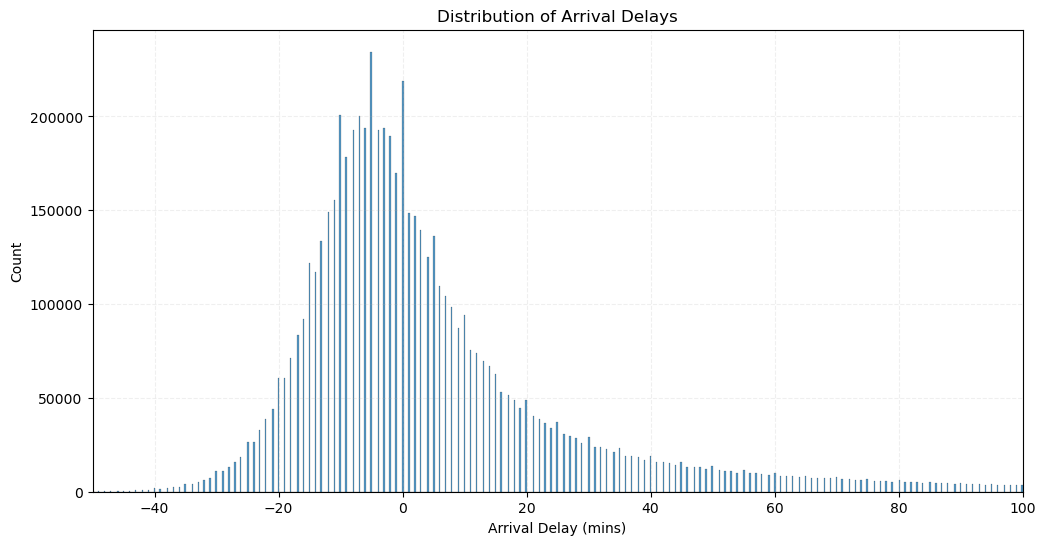

In [25]:
plt.clf()

fig, ax = plt.subplots(figsize=(12, 6)) #setting figure size as 12 by 6 inches on a subplot.

plot = sns.histplot(plane_df["ArrDelay"],bins="auto", linewidth=0.1) #histogram of arrival delays.
plot.set(xlim=(-50, 100)) #setting the x axis numerical range.
plot.set(title="Distribution of Arrival Delays", xlabel="Arrival Delay (mins)", ylabel="Count") #label and title setting.
plt.grid(True, linestyle="--", alpha=0.2) #gridline styles and transparency.
plt.show()

**GENERAL INSIGHTS** 
- Most data is centred around the -10 minute mark, suggesting that most flights actually arrive on time, or earlier than expected. There is a noticeable right skew, indicating that although rare, flights with delays of +60 minutes do occur.
- A flight can arrive very late, however, it is almost impossible for a flight to arrive hours earlier than expected.

**MACHINE LEARNING**
- Data may need to be transformed so that model is not biased towards more frequent minor delays.
- It could also be interesting to see what the underlying causes/common features of the extreme delays are.


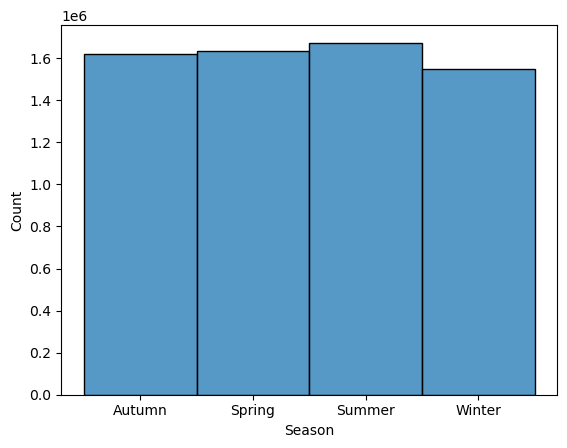

In [26]:
plt.clf()
sns.histplot(plane_df["Season"])
plt.show()

**GENERAL INSIGHTS** 
- Summer is the most popular flying season, whereas Winter is the least popular (Northern Hemisphere): Fluctuations across the year are seasonal, not drastically different at different times of year.

**MACHINE LEARNING**
- Good for ML, as all seasons are equally represented. No bias/overrepresentation of 1 particular season.

## Which Origin airports saw the longest arrival delays?
---

<Figure size 640x480 with 0 Axes>

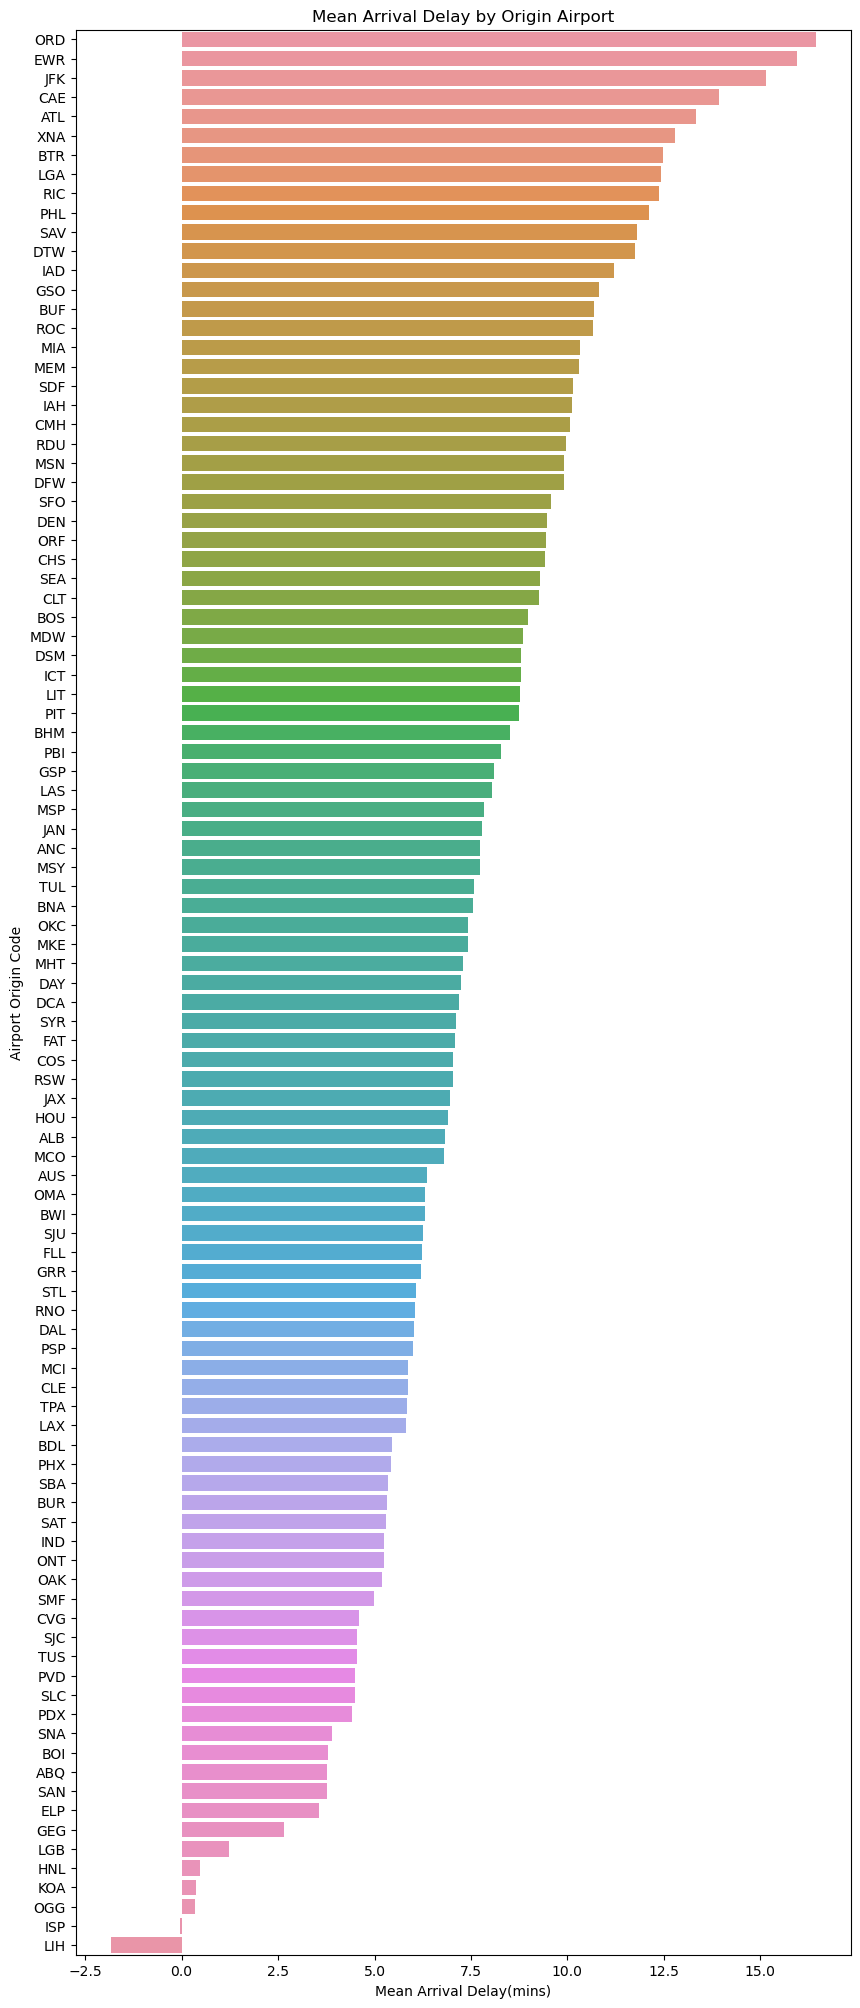

In [27]:
mean_origin_delay = plane_df.groupby("Origin")["ArrDelay"].agg(np.mean).sort_values(ascending=False) #grouping by airport of origin, aggregating the mean arrival delay.

plt.clf()

plt.figure(figsize=(10,25)) 
sns.barplot(x=mean_origin_delay.values, y=mean_origin_delay.index, order=mean_origin_delay.index) #order important to ensure the bars are ordered according to the indices in mean_origin_delay.
plt.title('Mean Arrival Delay by Origin Airport')
plt.xlabel('Mean Arrival Delay(mins)')
plt.ylabel('Airport Origin Code')
plt.show()


**GENERAL INSIGHTS** 
- Here we can see how average arrival delay varied by origin airport.
- Flights which originated from Chicago O'Hare International Airport, Newark Liberty International Airport and John F. Kennedy International Airport had the longest delays on arrival at the destination airport.
- This is most likely due to bottlenecks and operational inefficiencies at these mega-hubs, which transport millions of people each month.
- Origin Airports such as LIH, ISP and OGG show low or negative mean arrival delays. This could be due to them being small airports, low levels of air traffic or carfeully planned out flight schedules.

**MACHINE LEARNING**

- Data suggests that mean delays per airport can help in developing features for a predictive ML model.

## Which Destination airports saw the longest arrival delays?
---

<Figure size 640x480 with 0 Axes>

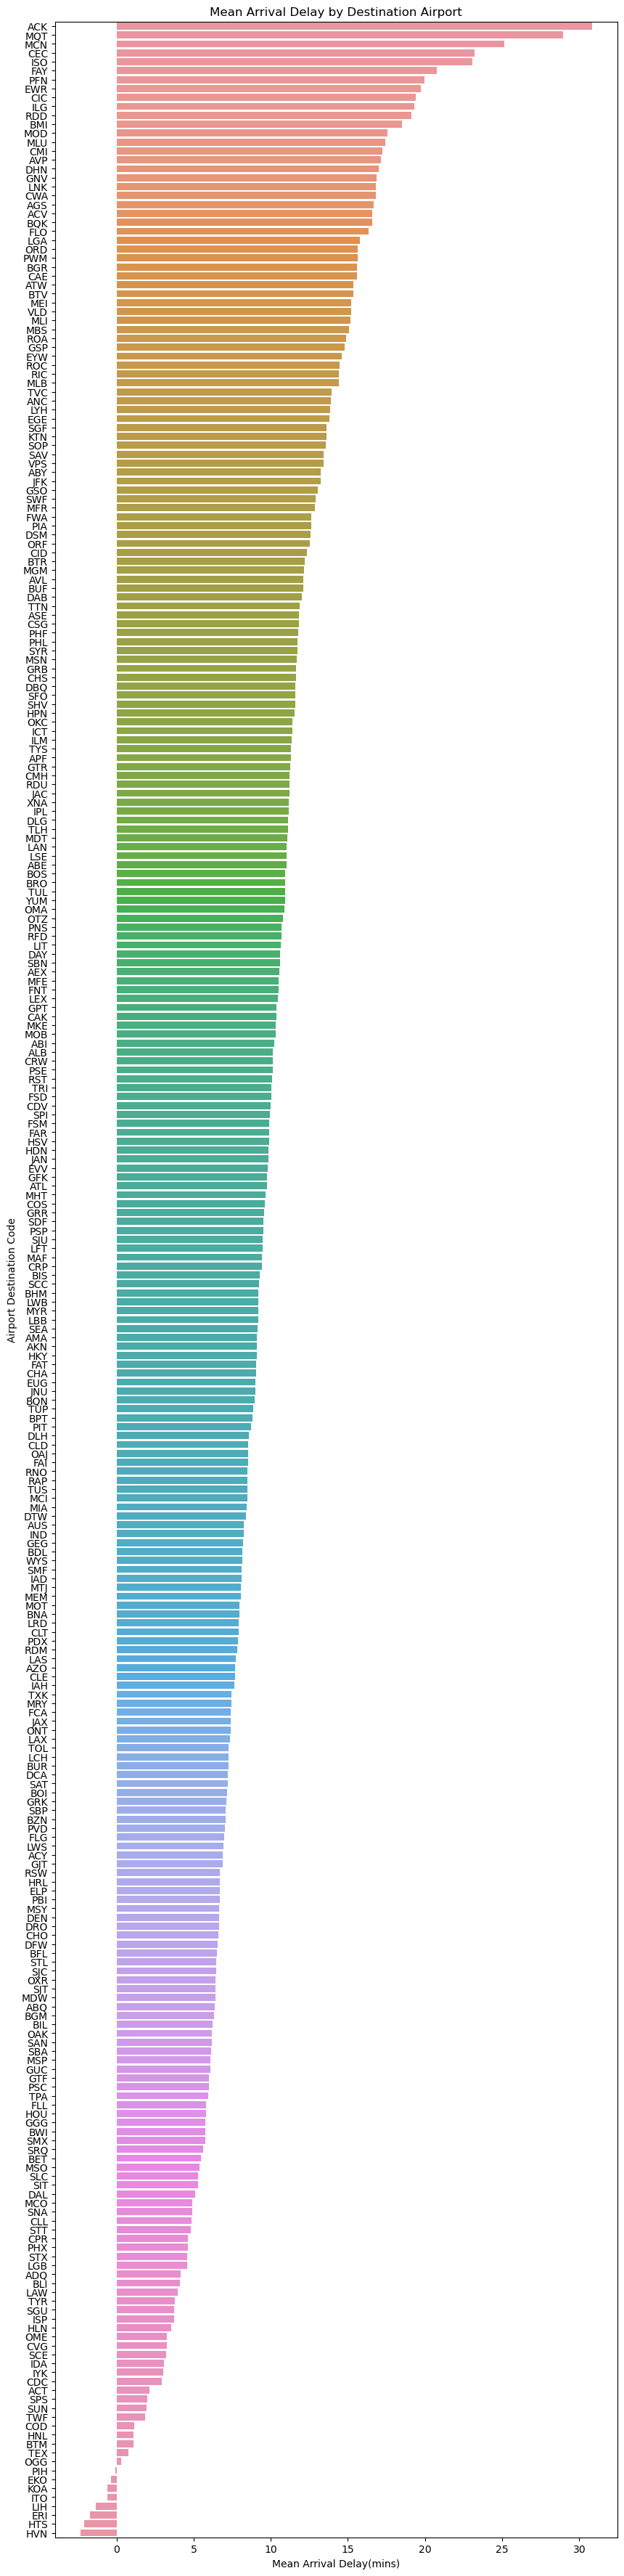

In [28]:
mean_dest_delay = plane_df.groupby("Dest")["ArrDelay"].agg(np.mean).sort_values(ascending = False) #similar process as above code, but for destination airports

plt.clf()
plt.figure(figsize=(10,45)) # Adjust this to change the size of your plot
sns.barplot(x=mean_dest_delay.values, y=mean_dest_delay.index, order=mean_dest_delay.index)
plt.title('Mean Arrival Delay by Destination Airport')
plt.xlabel('Mean Arrival Delay(mins)')
plt.ylabel('Airport Destination Code')
plt.show()


**GENERAL INSIGHTS** 

- Here we can see how average arrival delay varied by destination airport.
- Nantucket Memorial Airport had the longest mean arrival delay for a destination airport at ~37.5 minutes.
- Followed by Sawyer International Airport (~29 minutes) and Middle Georgia Regional Airport (25 minutes)
- Airports at the bottom (HVN, HTS, ERI, LIH and ITO) experienced flights arriving earlier than expected, on average.

**MACHINE LEARNING**

- Destination Airports can be a good feature for predicting delay.

## Does Flight Distance correlate with arrival delay?
---

A jointplot simultaneously shows the distribution of two numeric variables. Useful for seeing how variables relate to each other but also how their frequencies are distributed.

<Figure size 640x480 with 0 Axes>

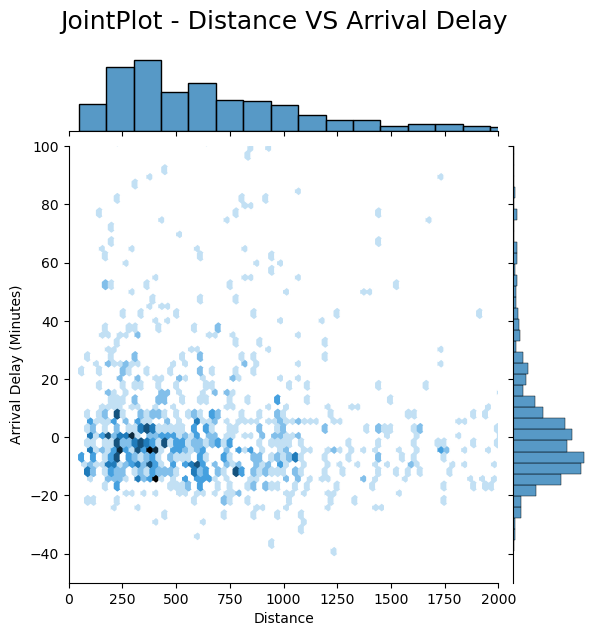

In [29]:
plt.clf()
sns.jointplot(x='Distance', y='ArrDelay', data=plane_df.sample(1000), kind='hex', gridsize=120) #Produces a jointplot with hexbins, taking a sample of 1000 rows from plane_df
plt.xlim(0,2000)
plt.ylim(-50,100)
plt.ylabel("Arrival Delay (Minutes)")
plt.title("JointPlot - Distance VS Arrival Delay", y=1.25, fontsize=18)
plt.show()


**GENERAL INSIGHTS** 
- Most flights are within the 250 to 750 mile distance range.
- Outliers are those that are upwards of 60 minutes late.
- Flights that cover the shorter distances seem to have a larger spread in delays than the longer haul flights.
- Most flights arrive on time or slightly early.

**MACHINE LEARNING** 
- There is no clear linear relationship present, meaning that a linear regression may not capture any relationship that well.
- Long flights may have built in "buffer time" to allow for delays - potenially needs to be considered in terms of feature interaction.
- The spread of data indicates that ensemble methods may be best for tackling this kind of dataset.



## Does Day of Week Correlate with Arrival Delay?
---

<Figure size 640x480 with 0 Axes>

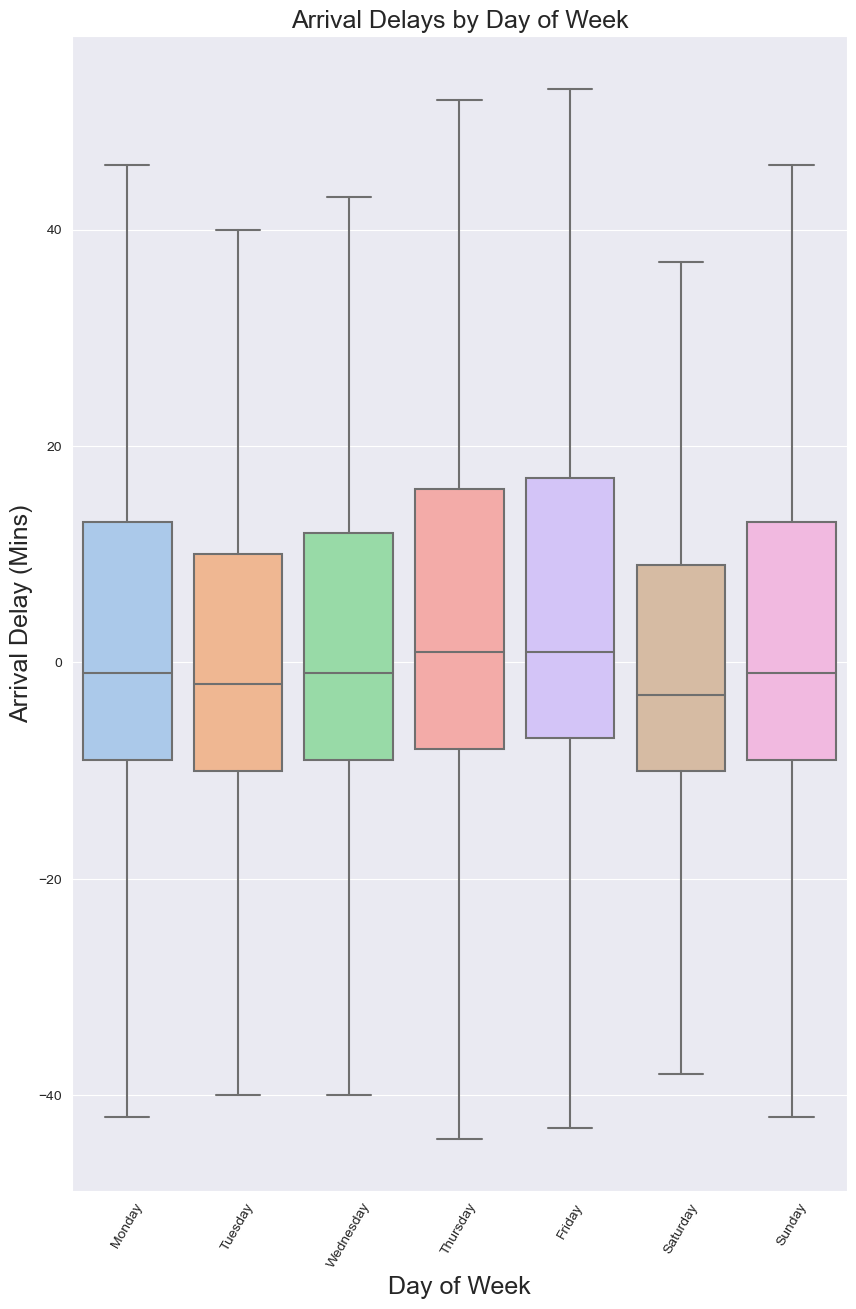

DayOfWeek
1     8.822503
2     6.246718
3     8.080851
4    11.747155
5    12.502239
6     5.122239
7     8.144593
Name: ArrDelay, dtype: float64


In [30]:
plt.clf()
sns.set_style("darkgrid")
plt.figure(figsize=(10,15)) 

sns.boxplot(y='ArrDelay', x='DayOfWeek', data=plane_df, showfliers = False, palette="pastel")
#Creates a boxplot with day of week on the x axis and arrival delay on the y axis.

plt.title('Arrival Delays by Day of Week', fontsize=18)
plt.xlabel('Day of Week', fontsize=18)
plt.ylabel('Arrival Delay (Mins)',fontsize=18)

labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"] #Setting custom labels instead of numbers 1 though 7.
plt.xticks(range(len(labels)), labels, rotation=60)

plt.show()

print(plane_df.groupby("DayOfWeek").mean()["ArrDelay"])

**GENERAL INSIGHTS** 
- Saturday has the lowest average arrival delay, whilst Fridays had the largest delays on average across 2006.
- This information could be used by people planning to travel who want to lower the chance of delays, particularly if they have time-bound events/responsbilities that they need to be timely for.
- Each day has a median delay close to 0 minutes - flights tend to arrive on time (+-10 minutes) irrespective of the day of the week. There is a noticeable difference between busier days like friday and calmer days like saturday.
- We can see that the IQR (the box) varies for each day
- Outliers fall outside the whiskers on the boxplot, indicating occassional significant delays.

**MACHINE LEARNING** : 
- Day of week appears to influence the distribution of delays, given that the pattern of delays across the week is not linear. 
- Thursday has a much wider spread of delays, whilst saturday is much more constrained with its window of delays.

## Does Month Correlate with Arrival Delay?
---

<Figure size 640x480 with 0 Axes>

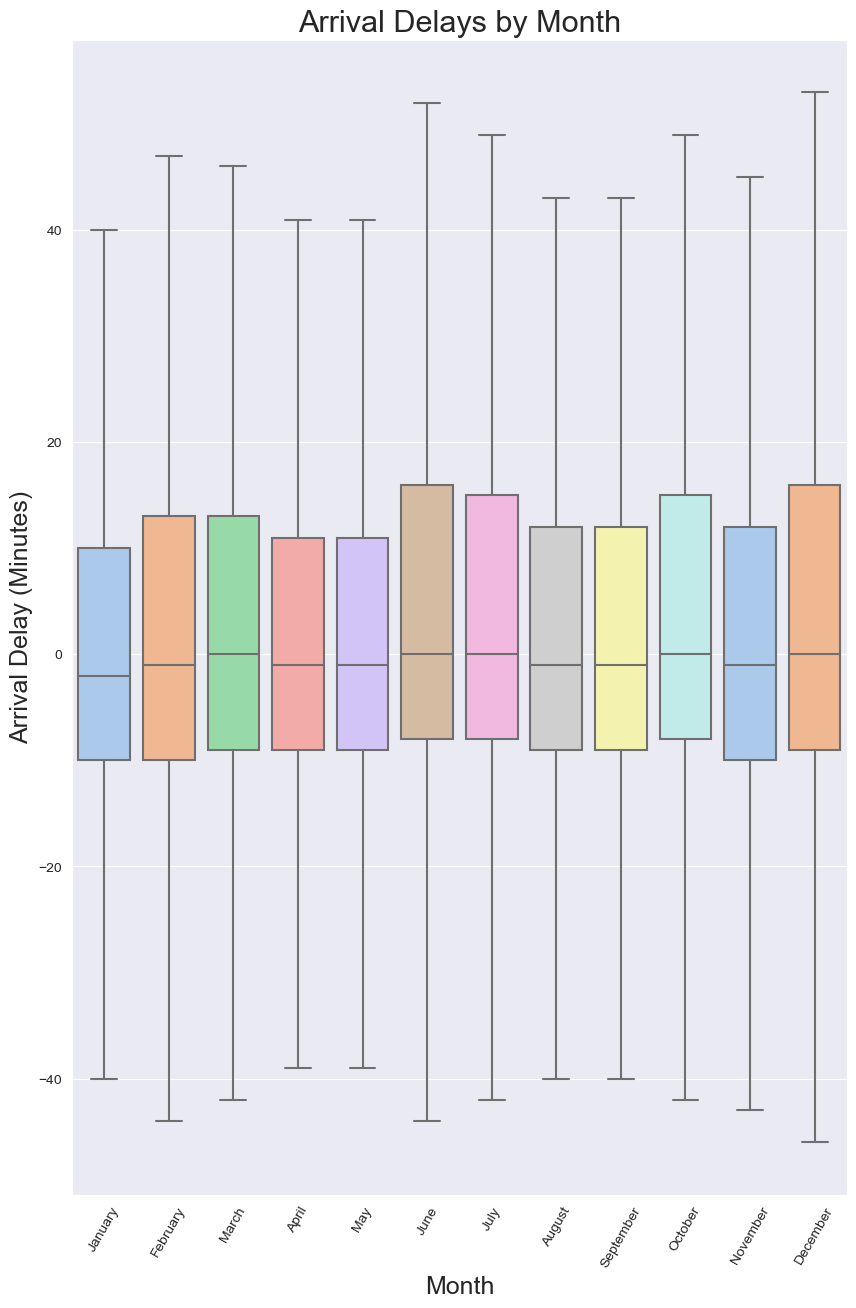

Month
1      5.734306
2      7.514640
3      7.984484
4      6.571704
5      7.005334
6     12.402196
7     11.531635
8      8.711912
9      8.265312
10    10.533721
11     7.338489
12    11.008170
Name: ArrDelay, dtype: float64


In [31]:
plt.clf()
plt.figure(figsize=(10,15)) 
sns.set_style("darkgrid")

#Creates a boxplot with Month on the x-axis and arrival delay on the y axis.
sns.boxplot(y='ArrDelay', x='Month', data=plane_df, showfliers = False, palette="pastel") #Outliers being shown.

plt.title('Arrival Delays by Month',fontsize=22)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Arrival Delay (Minutes)',fontsize=18)
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December'] #custom labels for months rather than numbers 1-12.
plt.xticks(range(len(labels)), labels, rotation=60)
plt.show()

print(plane_df.groupby("Month").mean()["ArrDelay"]) #Printing the mean arrival delay by month.

**GENERAL INSIGHTS** 
- June had the largest mean arrival delay, whilst January had the lowest mean arrival delay.
- This is probably due to the fact that Summer Holidays are a busy time for flights, whereas the month after the busy festive/new year period is somewhat calmer as people settle back into their daily routines. 
- There is a central tendency in the data. Flights tend to arrive on time or experience only slight delays (between 5.73 and 12.40 minutes)
- There is a difference in spread and variability between months. Busy months like June have a larger box, whilst others like April or May have a more contained/consistent set of delays.
- The fact that data exists below 0 in every month indicates flights arrive ahead of schedule very often.


**MACHINE LEARNING**
- Variability in delays across different months suggests potential seasonality in the data. 
- Seasonality/Months could be a useful feature for model creation.
- The spread and skewness of many months indicates ensembles and tree based methods may be good for capturing the trends shown in this data.


## Scheduled Departure Time VS Arrival Delay
---
- With departure time as minutes after midnight.

<AxesSubplot:>

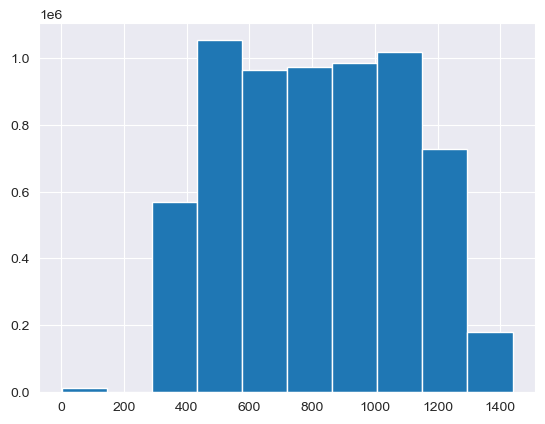

In [32]:
plane_df["CRSDepTimeMins_after_0000"].hist() #basic histogram plot

<Figure size 640x480 with 0 Axes>

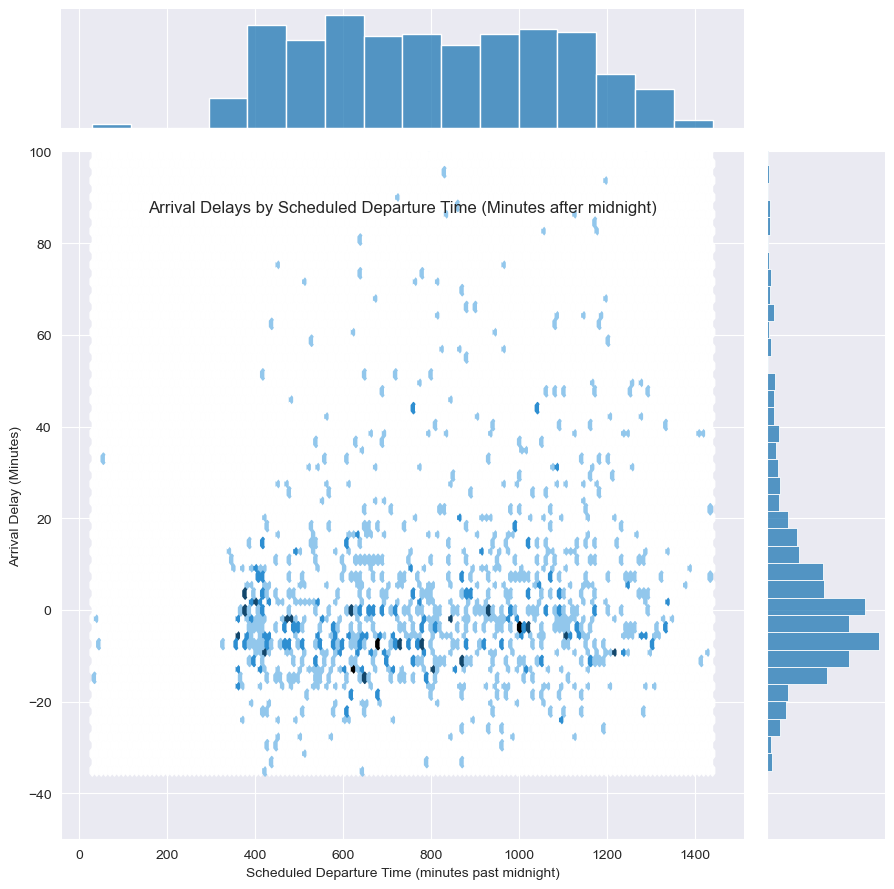

In [33]:
plt.clf()

fig = sns.jointplot(x="CRSDepTimeMins_after_0000", y='ArrDelay', data=plane_df.sample(1000), kind='hex', gridsize=140, height=9) #taking a sample of 1000 data points as to not over saturate the plot.

plt.ylim(-50,100)
plt.ylabel("Arrival Delay (Minutes)")
plt.title('Arrival Delays by Scheduled Departure Time (Minutes after midnight)', y=0.9)
plt.xlabel('Scheduled Departure Time (minutes past midnight)')

plt.show()

**GENERAL INSIGHTS**
- Fairly Uniform distribution of arrival delays when placed against departure time, with a gradual taper off as it approaches midnight(due to less flights occurring later in the day).
- The bulk of flights occur from around 400 minutes after midnight to 1300 minutes after midnight (0340 to 2140)
- There is a minor but noticeable concentration of delays in the 600-800 minute mark (morning/early afternoon)
- Flights occuring earlier in  day seem to arrive earlier than expected more than those after the 900 minute (1500) mark.
- Flights that are scheduled later in the day have a visibly smaller range of delays than those earlier in the day.

##### **MACHINE LEARNING**
- Given the varied occurence of delays at different times of the day, it makes sense to use scheduled departure time as a predictor for arrival delays.
- There is a skew in arrival delay, we may need to perform a log transformation in the next notebook.
- Not exactly a linear relationship, more effective models may be tree based or ensemble methods.
- The change over the course of the day indicates temporal changes influence arrival delay.


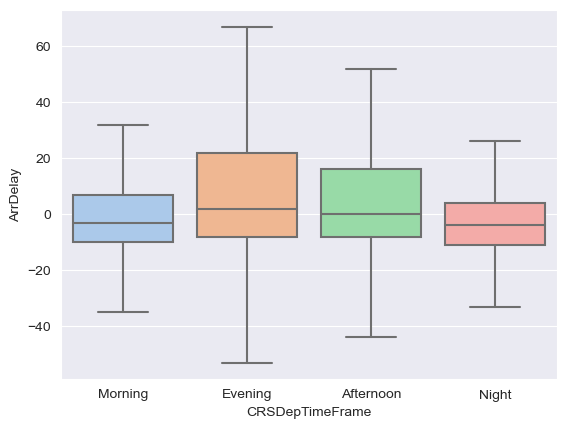

In [34]:
sns.boxplot(data=plane_df, x= "CRSDepTimeFrame", y="ArrDelay", showfliers= False, palette = "pastel")
plt.show()

**GENERAL INSIGHTS**
- On average, flights departing in the morning and at night had the lowest arrival delay. On average, these flights arrived earlier than they were scheduled to.
- Afternoon flights were more or less on time, whilst Evening flights were typically delayed by a few minutes.

**MACHINE LEARNING**
- Clear differences between categories; therefore should be used as a predictor.


## Departure Delay VS Arrival Delay
---
- These will inadvertently be correlated very closely. In the next notebook, this feature will only be used in the real-time prediction model.
- Very linear relationship, as expected


In [35]:
plane_df.head()

,Origin,Dest,Distance,DayOfWeek,DayofMonth,Month,Season,CRSDepTime,CRSDepTimeMins_after_0000,CRSDepTimeFrame,CRSElapsedTime,CRSArrTime,UniqueCarrier,origin_runways,destination_runways,total_runways,USair_congestion,total_flights_origin,total_flights_destination,DepDelay,ArrDelay,ArrDelayClass
0,CVG,CMH,116.0,1,19,6,Summer,10:30:00,630,Morning,48.0,1118,OH,4,2,6,18246,618,197,5.0,2.0,Slightly delayed
1,ATL,SGF,563.0,7,30,7,Summer,20:35:00,1235,Evening,112.0,2127,EV,5,2,7,18083,1972,27,153.0,136.0,Excessively delayed
2,PBI,BDL,1133.0,1,31,7,Summer,12:00:00,720,Afternoon,170.0,1450,DL,3,3,6,18956,138,189,0.0,-4.0,On-time
3,PIT,PHL,267.0,3,27,12,Winter,16:50:00,1010,Afternoon,70.0,1800,US,4,4,8,18814,278,592,-4.0,-11.0,On-time
4,ORD,ANC,2846.0,7,23,7,Summer,19:20:00,1160,Evening,399.0,2259,AS,11,3,14,18043,1806,121,8.0,-2.0,On-time


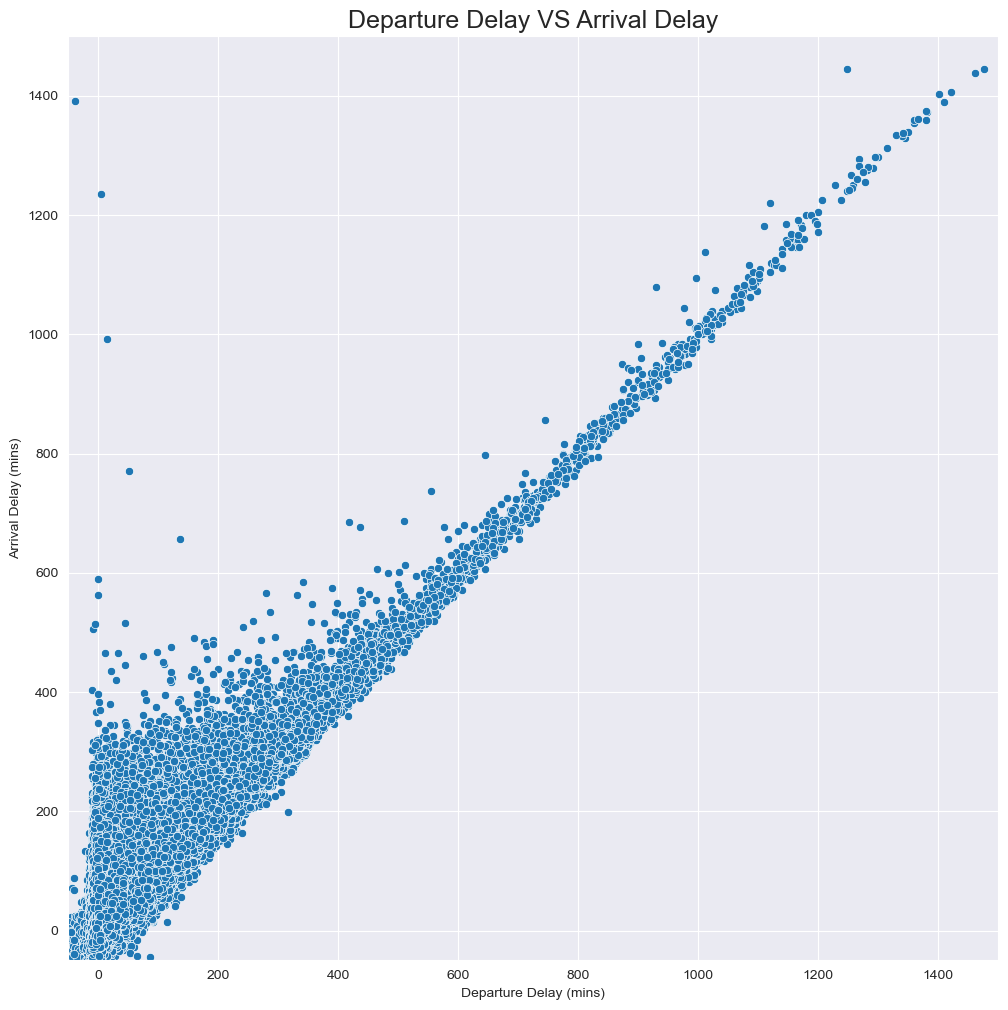

In [36]:
plt.figure(figsize=(12,12)) #initiate figure
sns.scatterplot(data=plane_df, x="DepDelay", y="ArrDelay") #Create a scatterplot of departure delay against arrival delay.
plt.xlim(-50,1500)
plt.ylim(-50,1500) #setting x and y limits.
plt.xlabel("Departure Delay (mins)")
plt.ylabel("Arrival Delay (mins)")
plt.title("Departure Delay VS Arrival Delay", fontsize=18)
plt.show()

**GENERAL INSIGHTS**
- As expected, these 2 variables are very strongly correlated.
- If a flight departs from the origin airport later than expected, it is unlikely that it will arrive on time at the arrival airport.
- Most points are relatively close to the diagonal line where x=y. Departure delay is more or less the same as arrival delay.
- Exceptions to the trend : For flights where departure delay is less than 400, flights often have even longer arrival delays. 
    - This could be due to air congestion and having to be in the air longer whilst waiting for a new appropriate landing window.
    - For example, many flights which had a delay of 50-100 mins, still had an arrical delay of upwards of 300 minutes.

    
##### **MACHINE LEARNING**
- Given the close correlation, departure delay should be a primary predictor for arrival delay
- As noted in the github repo, one set of models will use departure delay as a predictor, whilst the other will not.
- This is because departure delay is 'future information' - you do not know the departure delay of your flight until a given aircraft has taken off the origin runway.



## Scheduled Journey Time VS Arrival Delay

##### Does scheduled journey time influence delay on arrival?
---

<Figure size 640x480 with 0 Axes>

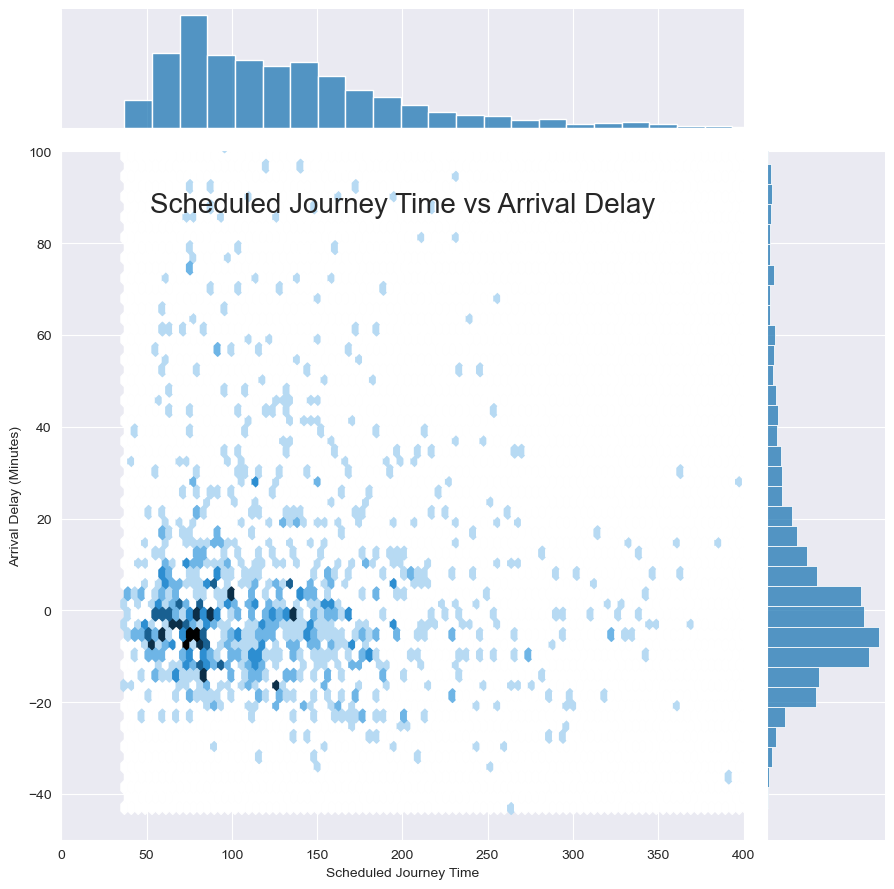

In [37]:
plt.clf()

fig = sns.jointplot(x="CRSElapsedTime", y='ArrDelay', data=plane_df.sample(1000), kind='hex', gridsize=140, height=9)

plt.ylim(-50,100)
plt.xlim(0,400)
plt.ylabel("Arrival Delay (Minutes)")
plt.title('Scheduled Journey Time vs Arrival Delay', y=0.9, fontsize=20)
plt.xlabel('Scheduled Journey Time')
plt.xticks()

plt.show()

**GENERAL INSIGHTS**
- Shorter flights were much more likely to experience longer delay times. This is possibly due to the fact that pilots have less time to "catch up" once theyve taken off, in comparison to longer haul flights.
- The hexplot shows that there is a high concentration of data points around the area where journey time 50 to 100 minutes and Arrival delay is around 0 minutes (moving into -20). Most flights occur within this range.
- Most of the delays are within 0 to 90 minute journey times, with longer haul flights experiencing a much narrower /occurence and range of delays.
- Flights that are longer than 250 minutes tended to have very minimal delays, with flights actually arriving earlier than expected quite often.
- Outliers present in the very long flights - arriving very early.

**MACHINE LEARNING**
- The hexplot seems to be quite dispersed, indicating that journey time may not be the best indicator of arrival delay. However, there may still be interaction effects with other variables that make it useful.
- There is a clear class imbalance in both journey times and arrival delays. May need to use a technique such as SMOTE in order to deal with these class imbalances.
- Could use an algorithm such as DBSCAN to find clusters and find groups of flights that behave similarly.

## How does the number of runways at airports influence Arrival Delay?
---

<Figure size 640x480 with 0 Axes>

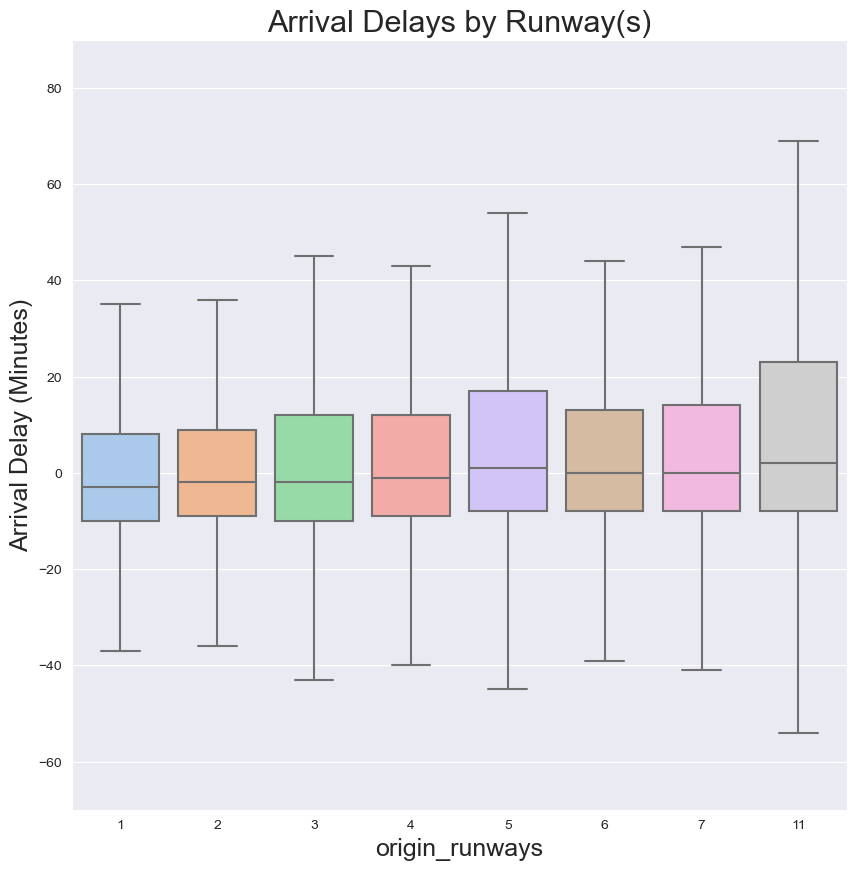

Average Delay (mins) by number of runways:  origin_runways
1      4.391685
2      6.492887
3      7.923922
4      7.856997
5     11.417793
6      8.882963
7      9.899621
11    16.433837
Name: ArrDelay, dtype: float64


<Figure size 640x480 with 0 Axes>

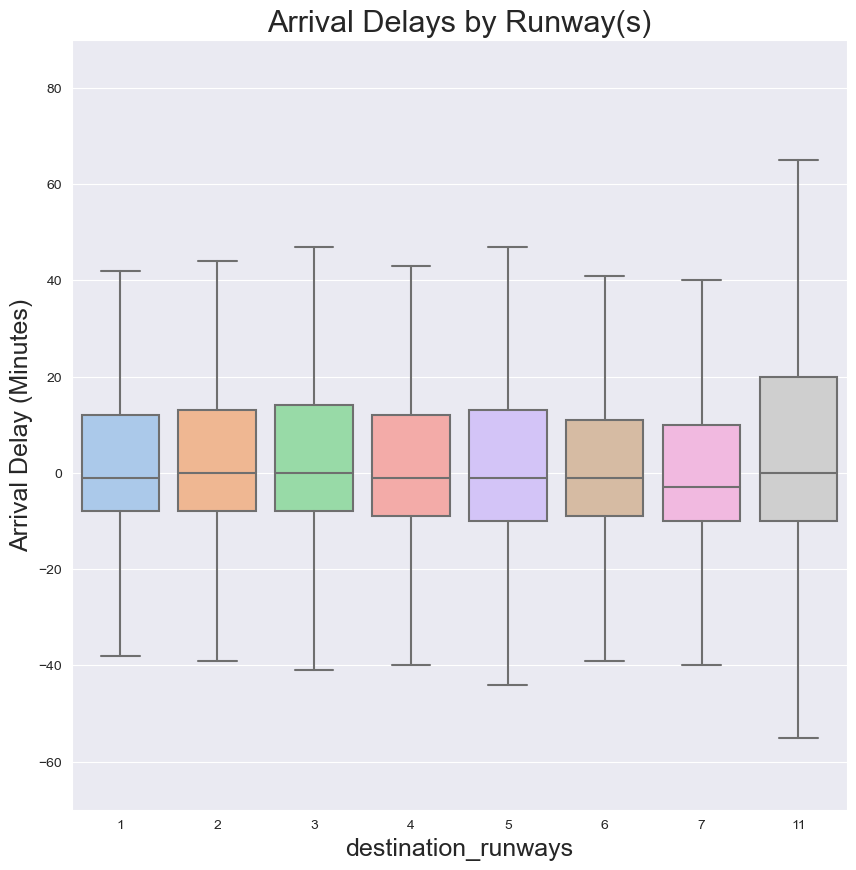

Average Delay (mins) by number of runways:  destination_runways
1      7.326184
2      9.127234
3      9.593624
4      7.735767
5      8.504200
6      7.543558
7      6.548503
11    15.652278
Name: ArrDelay, dtype: float64


<Figure size 640x480 with 0 Axes>

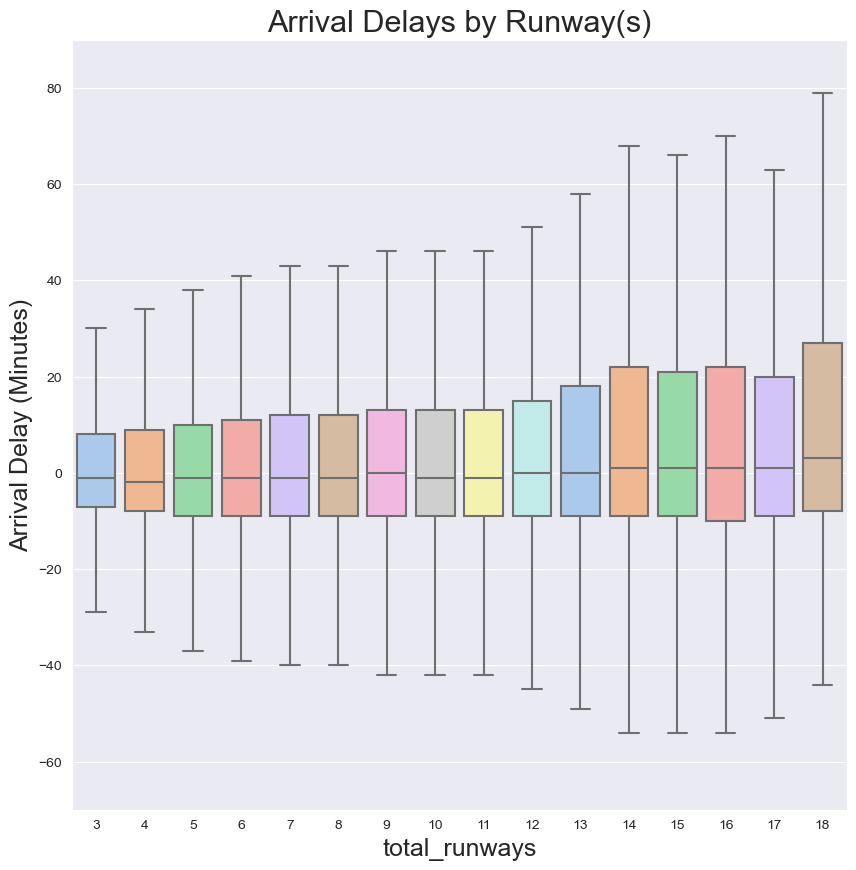

Average Delay (mins) by number of runways:  total_runways
3      4.731785
4      5.321836
5      6.689633
6      7.498810
7      7.718926
8      7.993255
9      8.705819
10     8.977112
11     8.296933
12    11.050781
13    13.770912
14    16.453106
15    15.922284
16    15.766837
17    14.762244
18    18.917107
Name: ArrDelay, dtype: float64


In [38]:
runways = ["origin_runways","destination_runways", "total_runways"] #selecting the columns which referred to runways in the plane_df dataframe.

for runway in runways:
    plt.clf()
    plt.figure(figsize=(10,10)) 
    sns.set_style("darkgrid")
    sns.boxplot(y='ArrDelay', x=runway, data=plane_df,showfliers = False,  palette="pastel")
    plt.title('Arrival Delays by Runway(s)',fontsize=22)
    plt.xlabel(runway, fontsize=18)
    plt.ylabel('Arrival Delay (Minutes)',fontsize=18)
    plt.ylim(-70,90)
    plt.show()
    print("Average Delay (mins) by number of runways: ",plane_df.groupby(runway).mean()["ArrDelay"])
    

#### Creating Visualisations for variation in mean delays between number of runways and runway types


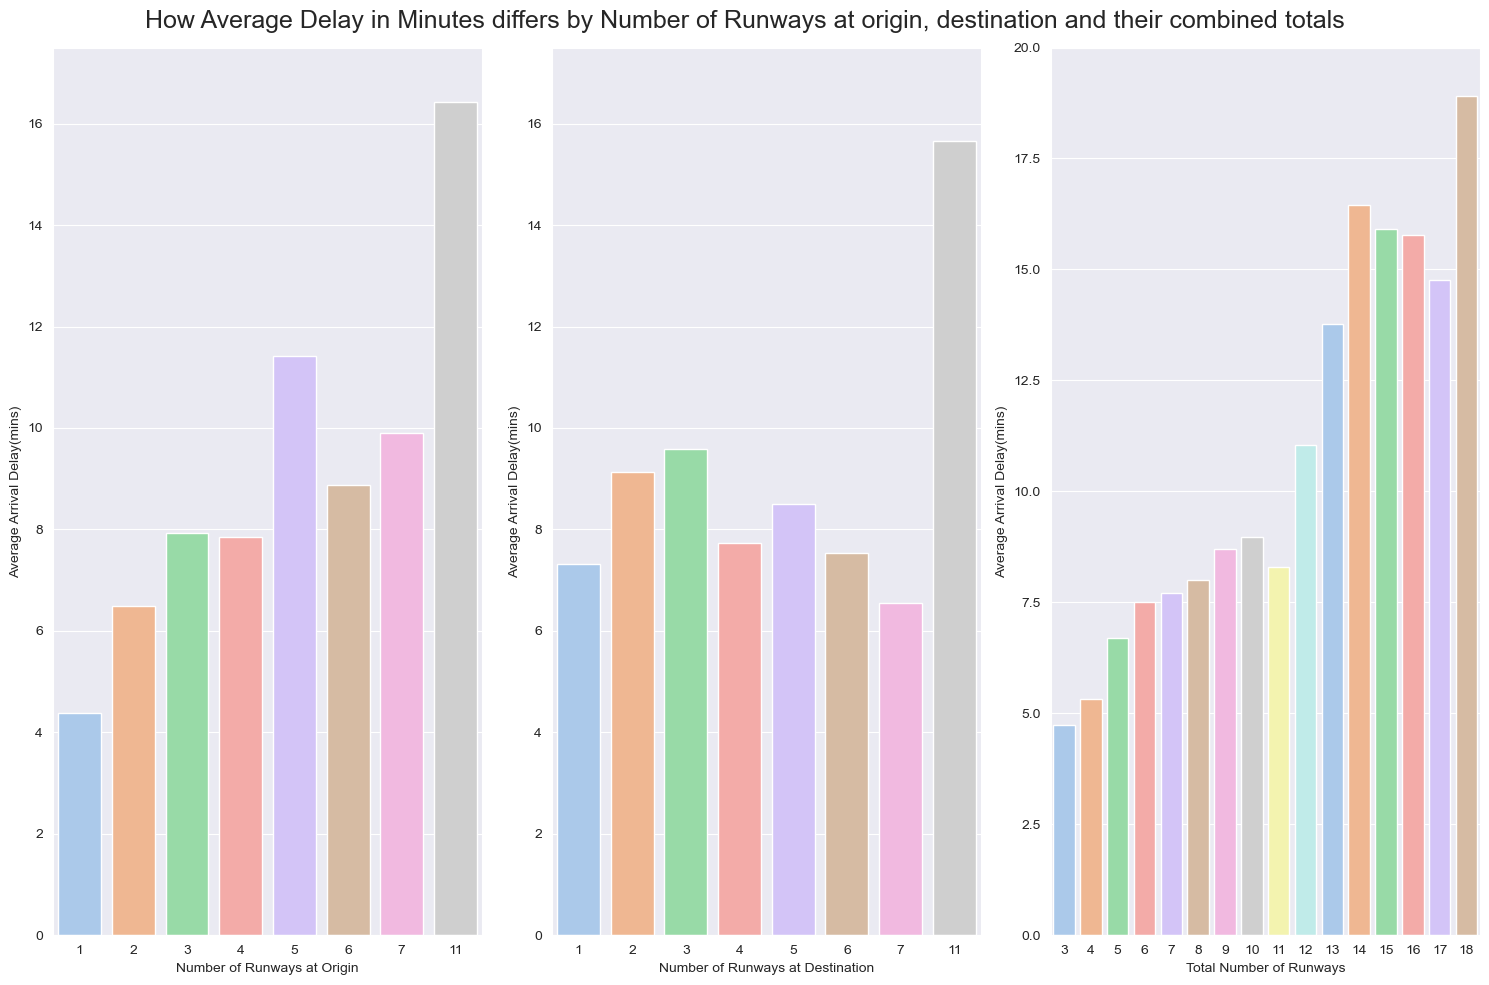

In [39]:
runways = ["origin_runways","destination_runways", "total_runways"]
runways_dict={} #Initialising an empty dictionairy, where we will store the upcoming dataframes.

for runway in runways:
    runways_dict[runway] = pd.DataFrame(plane_df.groupby(runway).mean()["ArrDelay"]) #Data grouped by runway type, with its mean then taken. Key value pair are then assigned to dictionairy.
    

df_origin_runways = runways_dict["origin_runways"]
df_destination_runways = runways_dict["destination_runways"]
df_total_runways = runways_dict["total_runways"]

df_origin_runways.reset_index(inplace=True)
df_destination_runways.reset_index(inplace=True) #Converting each datframes index back to an integer based one.
df_total_runways.reset_index(inplace=True)


#visualisation
fig, axs = plt.subplots(1, 3, figsize=(15,10))   #1 row and 3 columns of plots within the main subplot.
fig.suptitle('How Average Delay in Minutes differs by Number of Runways at origin, destination and their combined totals', fontsize=18) #Title for the entire subplot.

sns.barplot(data=df_origin_runways, x="origin_runways", y="ArrDelay", ax=axs[0], palette="pastel") #For each of these, we select the relevant dataframe and axis to draw the barplot on.
sns.barplot(data=df_destination_runways, x="destination_runways", y="ArrDelay", ax=axs[1],palette="pastel")
sns.barplot(data=df_total_runways, x="total_runways", y="ArrDelay", ax=axs[2],palette="pastel")

#In order to make the visualisaion more aesthetically pleasing, we can customise the individual axes and labels for each plot.

axs[0].set_ylim([0,17.5])
axs[0].set_xlabel("Number of Runways at Origin")
axs[0].set_ylabel("Average Arrival Delay(mins)")

axs[1].set_ylim([0,17.5])
axs[1].set_xlabel("Number of Runways at Destination")
axs[1].set_ylabel("Average Arrival Delay(mins)")

axs[2].set_ylim([0,20])
axs[2].set_xlabel("Total Number of Runways")
axs[2].set_ylabel("Average Arrival Delay(mins)")


plt.tight_layout()
plt.show()


**GENERAL INSIGHTS**
- Origin and Destination Airports with only 1 runway tended to have the most consistent delays with a median of around 0 minutes.
- As the number of origin runways increases, the median delay also tends to trend slightly upwards.
- This is less so the case for destination runways, where the median arrival times tend to stay the same (0) or slightly decrease.
- As the number of total runways in a journey increases, the median arrival time increases slightly. The IQR increases as runways increases, as do the ranges of the whiskers.
- There seems to be a linear relationship for origin and total runways.
- For destination runways, delays seem to rise up until 3 runways, then slowly decrease. It jumps very high for 11 runways, however this is probably heavily skewed as there are limited airports with 11 runways.

**MACHINE LEARNING**
- Number of runways as a metric influences arrival delays and should be used as a variable in an ML problem.
- The AVERAGE delay for a journey with 3 runways is 4.73 minutes, whereas for a journey with 18 has 18.9 minutes delay on average.


## Delays By Airline (Carrier Code)
---

<Figure size 640x480 with 0 Axes>

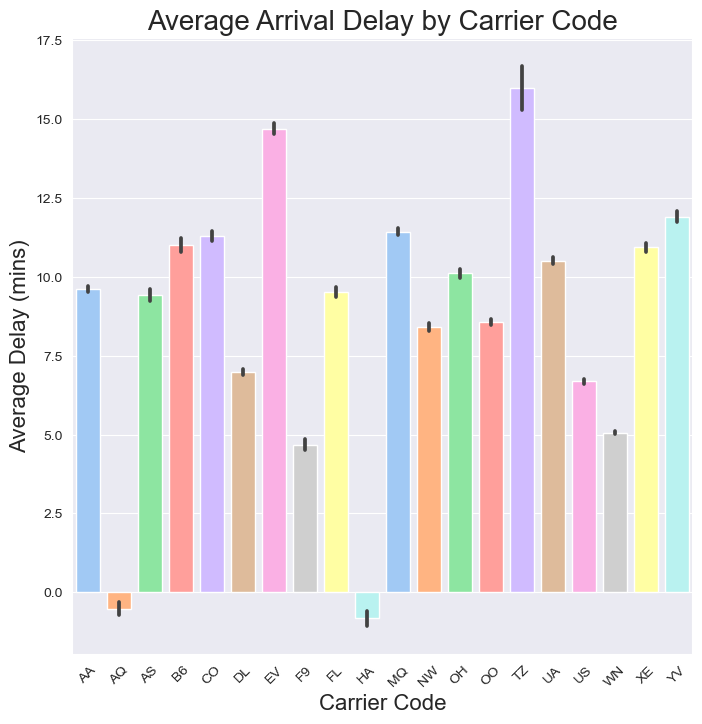

In [40]:
plt.clf()
sns.set_style("darkgrid")
plt.figure(figsize=(8, 8))
sns.barplot(data = plane_df, x="UniqueCarrier", y="ArrDelay", saturation=1, palette="pastel") #Unique carrier is airline.
plt.title("Average Arrival Delay by Carrier Code", fontsize=20)
plt.xlabel("Carrier Code", fontsize=16)
plt.ylabel("Average Delay (mins)", fontsize=16)
plt.xticks(rotation=45)
plt.show()

**GENERAL INSIGHTS**
- Some airlines may have worse operational practices and therefore be less efficient. (Scheduling, baggage handling, turnaround times)
- Some airlines may have older aircraft, more prone to longer grounding periods to deal with mechanical issues, thus putting additional pressure on other planes in the fleet.
- Some carriers may fly a large proportion of their flights between airports where delays are more common (More an issue with the airport rather than the carrier)
- We can see that HA (Hawaiian Airlines) flights arrived ahead of schedule on average. Same goes for AQ (Aloha) airline.
- The majority of carriers can see their average delays falling within the 7.5 to 12.5 minute range.
- Airlines such as TZ experience more variability in their delay times.

##### **MACHINE LEARNING**
- Values here suggest delays by airline can be a siginificant predictor of arrival delay.
- K- Means could be used in order to group carriers based on delay patterns.


## Which Weekday & Month had the most flights?
---

,Day_of_Week,Number_Flights
0,1,950958
1,2,936781
2,3,945791
3,4,951048
4,5,954927
5,6,818088
6,7,918868


Text(0.5, 1.0, 'Number of Flights per Weekday in 2006')

<Figure size 640x480 with 0 Axes>

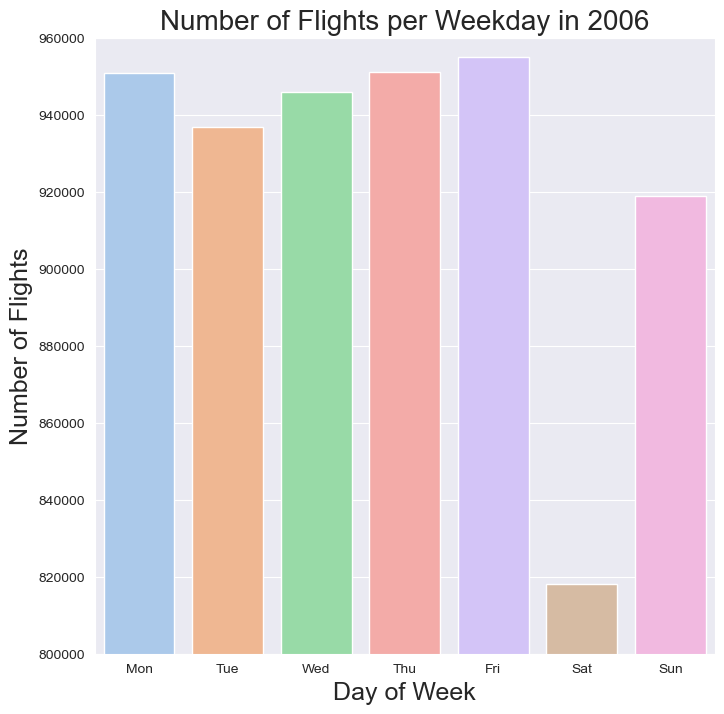

In [41]:
flights_by_weekday = plane_df.groupby("DayOfWeek").size() #Grouping our main dataframe by day of week and counting occurences within each group.

flights_by_weekday_df = flights_by_weekday.reset_index() #resetting the index.
flights_by_weekday_df.columns = ['Day_of_Week', 'Number_Flights'] #Renaming columns for ease of readability.
display(flights_by_weekday_df)

#Creating a barplot of weekday against daily flights
plt.clf()
sns.set_style("darkgrid")
plt.figure(figsize=(8, 8))
sns.barplot(data=flights_by_weekday_df, x="Day_of_Week", y="Number_Flights", palette="pastel")
plt.ylim([800000,960000])
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(range(len(labels)), labels)
plt.xlabel("Day of Week", fontsize=18)
plt.ylabel("Number of Flights", fontsize=18)
plt.title("Number of Flights per Weekday in 2006", fontsize=20)

**GENERAL INSIGHTS**
- This can partly explain why Friday had the longest average delays and Saturday the shortest. They are the most popular and least popular travel days respectively.
- There were approximately 140000 less flights between the busiest and calmest days of the week (Friday and Saturday).
- People often go away for the weekend on Friday evenings. People do not want to be flying over the weekend, particularly if these are their days off.
- Airlines can determine patterns in flights. People may fly and return on Monday/Friday & Friday/Sunday, which could prompt them to offer special offers to garner even more customers.

**MACHINE LEARNING**
- Given that air congestion is linked to higher delays - congestion by day of week could be a useful predictor of arrival delays.


,Month,Number_Flights
0,1,526271
1,2,478915
2,3,551124
3,4,534532
4,5,550199
5,6,541883
6,7,561799
7,8,570121
8,9,530548
9,10,555065


Text(0.5, 1.0, 'Number of Flights per Month in 2006')

<Figure size 640x480 with 0 Axes>

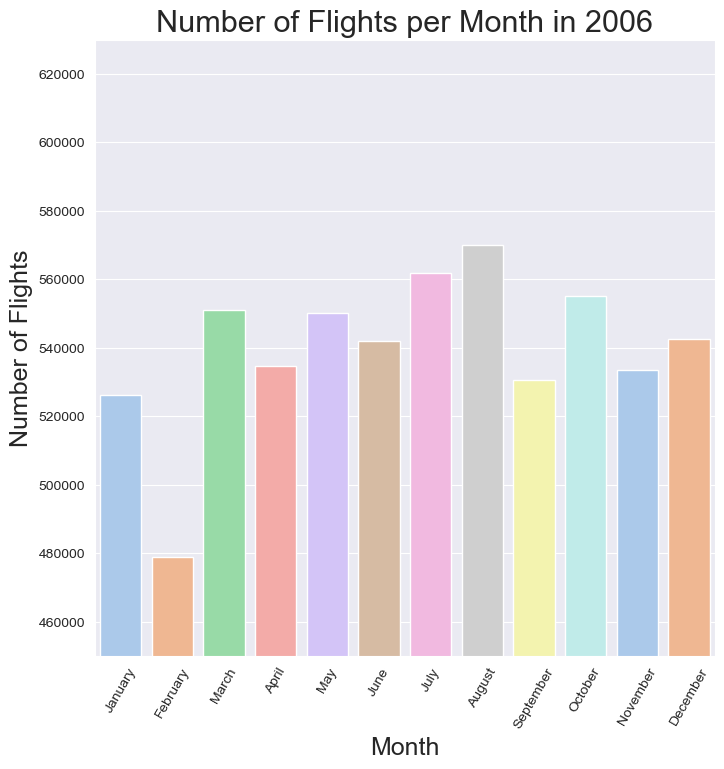

In [42]:
flights_by_month = plane_df.groupby("Month").size() #Grouping data by month and counting occurences for each group

flights_by_month_df = flights_by_month.reset_index()
flights_by_month_df.columns = ['Month', 'Number_Flights']#resetting index + naming columns
display(flights_by_month_df)

plt.clf()
sns.set_style("darkgrid")
plt.figure(figsize=(8, 8))
sns.barplot(data=flights_by_month_df, x="Month", y="Number_Flights", palette='pastel')
plt.ylim([450000, 630000])
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December'] 
plt.xticks(range(len(labels)), labels, rotation=60) #setting +  implementing custom labels
plt.xlabel("Month", fontsize=18)
plt.ylabel("Number of Flights", fontsize=18)
plt.title("Number of Flights per Month in 2006",fontsize=22)

**GENERAL INSIGHTS**
- February had the least flights, whilst August had the most flights followed by July, indicating that the Summer period is at its peak here.
- February having the least flights can be explained by reduced travel following the holiday period, winter conditions and only having 28/29 days in a month.
- The popularity of a flying weekday/month can explain the average delay relatively well.

**MACHINE LEARNING**
- The data suggests a a cyclical nature of flight patterns across the seasons.
- Seasonal data could be used to predict arrival delay.



## What were the busiest and calmest days of the year?
---

In [43]:
#Creating a new date column and converting to a recognisable datetime format.
plane_df["Date"] = pd.to_datetime('2006-' + plane_df["Month"].astype(str) + '-' + plane_df["DayofMonth"].astype(str), format='%Y-%m-%d')
#Grouping data by individual date (day of the year 2006) and storing number of occurences.
daily_flights = plane_df.groupby("Date").size()

#Printing out the 10 busiest and 10 calmest travel days of the year 2006.
print(daily_flights.nlargest(10))
print(daily_flights.nsmallest(10))

Date
2006-08-17    19082
2006-08-04    19072
2006-08-18    19064
2006-07-07    19059
2006-08-14    19038
2006-11-22    19028
2006-07-10    19010
2006-07-06    19001
2006-07-14    19001
2006-11-27    18981
dtype: int64
Date
2006-02-12    13778
2006-11-23    13891
2006-02-11    14250
2006-01-21    14491
2006-02-04    14543
2006-01-28    14544
2006-01-14    14563
2006-09-23    14855
2006-02-18    14875
2006-01-07    14927
dtype: int64


- The top 3 busiest travel days were all in august. In general, most busy flight days were over the summer period where lot of people like to go away on holidays.
- From the top 10 least popular days of the year to fly, 8 were in either January or February.

## Time Series Plot
---
 - The objective here is to create a time series plot where the frequency of flights can be smoothly visualised across a whole year.

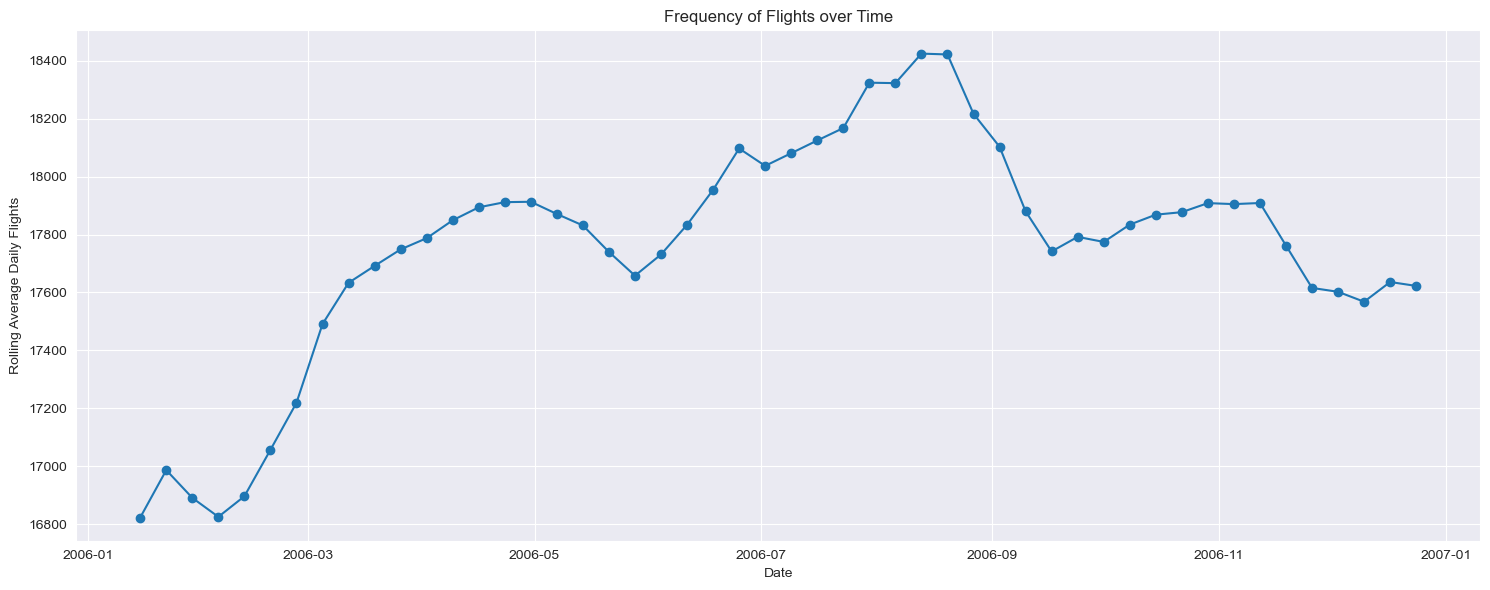

In [44]:
#In the code above, we created a series where we had each date in 2006 paired with the number of flights in the year.
#Note: the date is in datetime format, allowing us to resample by week.
#Below, we resample by week, and take the mean of the flights for each week.
weekly_flights = daily_flights.resample('w').mean()

#Rolling Mean over 2 month period
#Creating another series object using an 4 week window that is centred.
#For example, to calculate the rolling average for the 10th week of the year using 8 week window, we would average from week 3 to 10.
#The rolling average creates the smoothness in the graph
#The rolling average is centred, which means the current data point is seen as the centre of the window rather than end.
#This is useful for data points at the start of the year, as there is no data (available here) before january 2006. By centering around current point, Jan 1st would get 2 weeks ahead to find a rolling average.
smoothed_flights = weekly_flights.rolling(window=4, center=True).mean()


#Plotting the above data on a lineplot
plt.figure(figsize=(15, 6))
plt.plot(smoothed_flights, marker='o')

plt.title('Frequency of Flights over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Average Daily Flights')


plt.tight_layout() #neater display 
plt.show()


**GENERAL INSIGHTS**
- The 2 month rolling average time series above shows how the number of flights steadily increased over the course of the year up until late august, before starting to decline again.

## Creating a Calendar Mapping
---

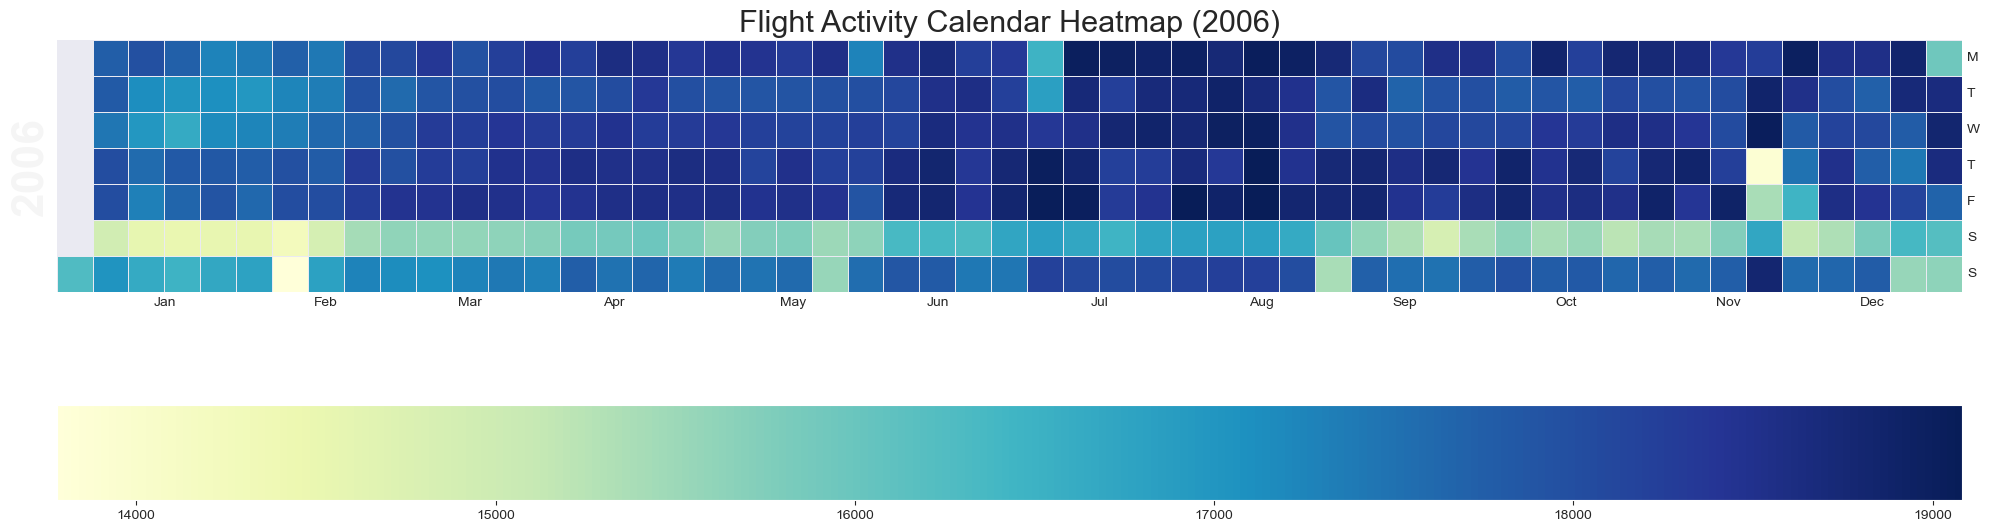

In [45]:
import calmap #used in the creation of calendar heatmaps.

fig, ax = calmap.calendarplot(daily_flights, monthticks=1, daylabels='MTWTFSS',
                    dayticks=1, cmap='YlGnBu', linewidth=0.5,
                    fig_kws=dict(figsize=(20, 8)))

#daily_flights is the data we want to plot. monthticks being set to 1 makes sure each month is labelled on the calendar. daylabels provides the days of the week on the right of the calendar heatmap.

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation='horizontal')
#The colorbar acts as a legend.
#get_children retrieves the  heatmap for the axis. 
#.ravel, flattens the axis so the colorbar stretches across the whole object.

plt.title('Flight Activity Calendar Heatmap (2006)', fontsize=22)

plt.show()

**GENERAL INSIGHTS**
- The calendar mapping above allows us to see any outliers in our data, as well as trend across the year.
- We can see that there were certain days less busy than normal, such as a Sunday in February, and days towards the end of the year, probably due to it being a holiday season.
- There are certain which were unexpectedly calm, such as the 2nd Thursday in November.
- Dark Blue patches (such as the 2nd Sunday in November) indicate higher air traffic.

## Next Notebook
--- 
- The next notebook will use the Machine Learning insights found in this notebook and apply them to create robust models for predicting the class of arrival delay for a given flight.
